**Import necessary libraries**

In [1]:
import torch
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.datasets import MNIST
from PIL import Image
from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix, multilabel_confusion_matrix
from sklearn.preprocessing import label_binarize

# Import functions from helper.py
from helper import *
from models import CNN_for_DeepFake

In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


**Data Loading and Preprocessing**

In [3]:
# Get transformations
original_transform = get_original_transform()
augmented_transform = get_augmented_transform()

In [4]:
# Load the dataset from the directory
raw_dataset = datasets.ImageFolder(root='../processed_dataset_frame/processed_dataset_frame', transform=None)

# Access a raw image and its label directly
raw_img, label = raw_dataset[0]

# Now apply the transformations to the raw PIL image for demonstration
img_original_tensor = original_transform(raw_img)
img_augmented_tensor = augmented_transform(raw_img)

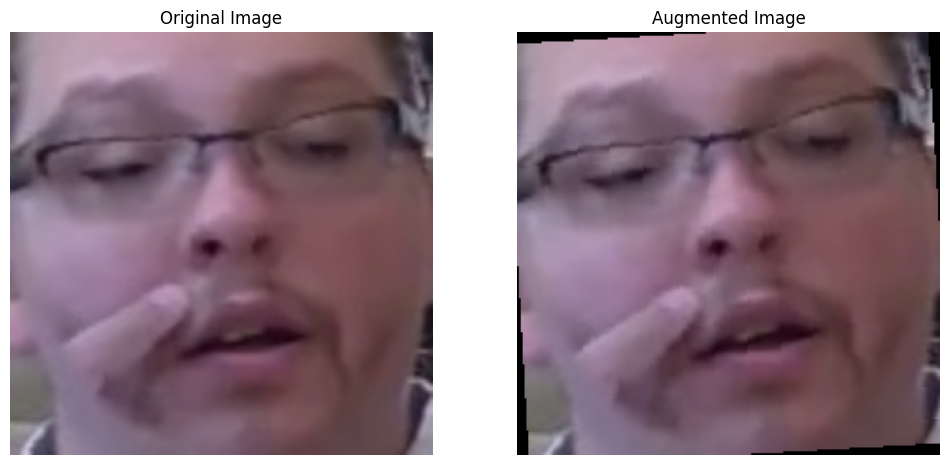

In [5]:
# Access the raw image and its label from dataset
img, label = raw_dataset[0]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Displaying the original image and the augmented image
show_image(img_original_tensor, title='Original Image', ax=axs[0])
show_image(img_augmented_tensor, title='Augmented Image', ax=axs[1])

plt.show()

In [6]:
# Create the dataloders
root_directory = '../processed_dataset_frame/processed_dataset_frame'
test_directory = '../processed_dataset_frame_test'
batch_size = 16
train_loader, validation_loader, test_loader = setup_data_loaders(root_directory, test_directory, batch_size)

**Define the CNN Model**

**Initialize CNN Model**

In [7]:
model = CNN_for_DeepFake(dropout_rate=0.25, fc_units=64)
model.to(device)  

CNN_for_DeepFake(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=200704, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout3): Dropout(p=0.25, inplace=False)
)

**Train and evaluate the model (Single trial)**

In [8]:
train_accuracies, test_accuracies, validation_accuracies, train_losses, test_losses, validation_losses = train_and_evaluate(model, train_loader, validation_loader, test_loader, epochs=20, lr=1e-4)

d:\Users\ZJY\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, Train Loss: 2.8179, Validation Loss: 1.6365, Test Loss: 4.2536, Train Accuracy: 63.72%, Validation Accuracy: 72.00%, Test Accuracy: 47.99%
--------------------------------------------------------------
Epoch 2, Train Loss: 1.8130, Validation Loss: 1.0143, Test Loss: 2.4877, Train Accuracy: 71.09%, Validation Accuracy: 75.10%, Test Accuracy: 54.80%
--------------------------------------------------------------
Epoch 3, Train Loss: 1.2048, Validation Loss: 0.8123, Test Loss: 1.8300, Train Accuracy: 74.42%, Validation Accuracy: 77.62%, Test Accuracy: 58.04%
--------------------------------------------------------------
Epoch 4, Train Loss: 0.8121, Validation Loss: 0.6342, Test Loss: 2.0865, Train Accuracy: 77.50%, Validation Accuracy: 78.63%, Test Accuracy: 50.45%
--------------------------------------------------------------
Epoch 5, Train Loss: 0.5814, Validation Loss: 0.4336, Test Loss: 1.6464, Train Accuracy: 80.81%, Validation Accuracy: 81.64%, Test Accuracy: 53.12%
--------

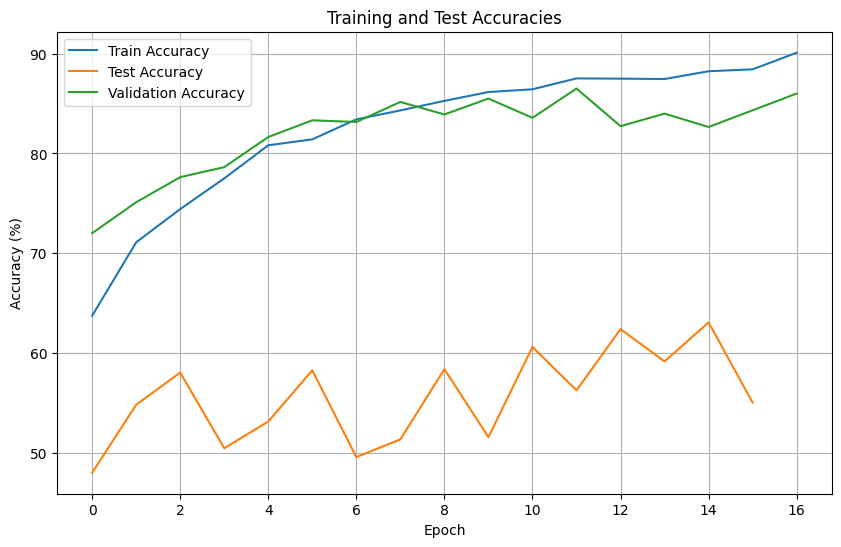

In [13]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracies')
plt.legend()
plt.grid(True)
plt.show()

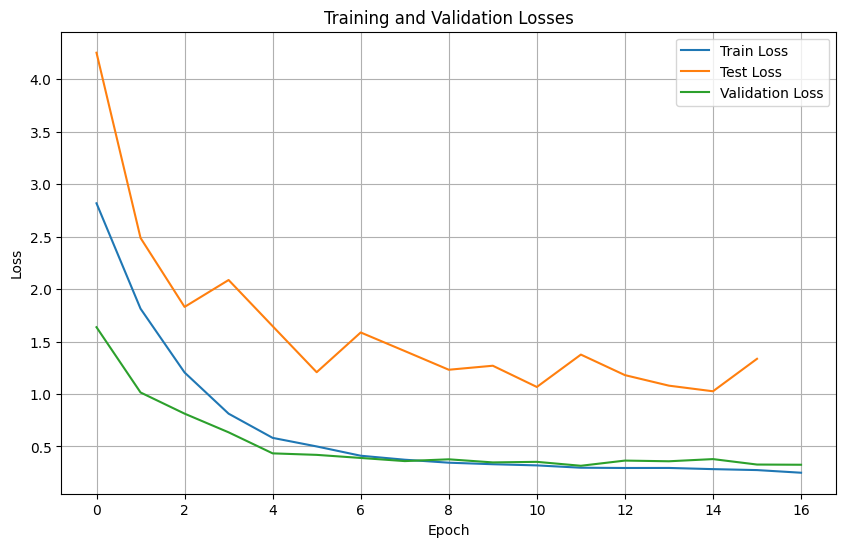

In [14]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

**Hyperparameter Search**

In [8]:
hyperparameters = {
    'learning_rate': [1e-3, 1e-4, 1e-5],
    'dropout_rate': [0.25, 0.5],
    'fc_units': [64, 128, 256, 512]
}

In [9]:
results, best_model_path = random_search_CNN(hyperparameters, num_trials=10)

Trial 1: Training with lr=0.0001, dropout=0.5, fc_units=128


d:\Users\ZJY\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, Train Loss: 4.4434, Validation Loss: 1.4988, Test Loss: 3.1738, Train Accuracy: 61.16%, Validation Accuracy: 70.83%, Test Accuracy: 58.04%
--------------------------------------------------------------
Epoch 2, Train Loss: 2.8485, Validation Loss: 1.2374, Test Loss: 2.7404, Train Accuracy: 68.14%, Validation Accuracy: 74.85%, Test Accuracy: 59.49%
--------------------------------------------------------------
No improvement in validation loss for 1 epochs...
Epoch 3, Train Loss: 1.9903, Validation Loss: 2.0946, Test Loss: 0.6895, Train Accuracy: 69.87%, Validation Accuracy: 65.63%, Test Accuracy: 85.16%
--------------------------------------------------------------
Epoch 4, Train Loss: 1.4461, Validation Loss: 1.0820, Test Loss: 0.8166, Train Accuracy: 72.19%, Validation Accuracy: 70.49%, Test Accuracy: 76.90%
--------------------------------------------------------------
Epoch 5, Train Loss: 0.8875, Validation Loss: 0.7184, Test Loss: 0.9710, Train Accuracy: 75.04%, Validatio

**Visualize the accuracy and loss obtained for all trials**

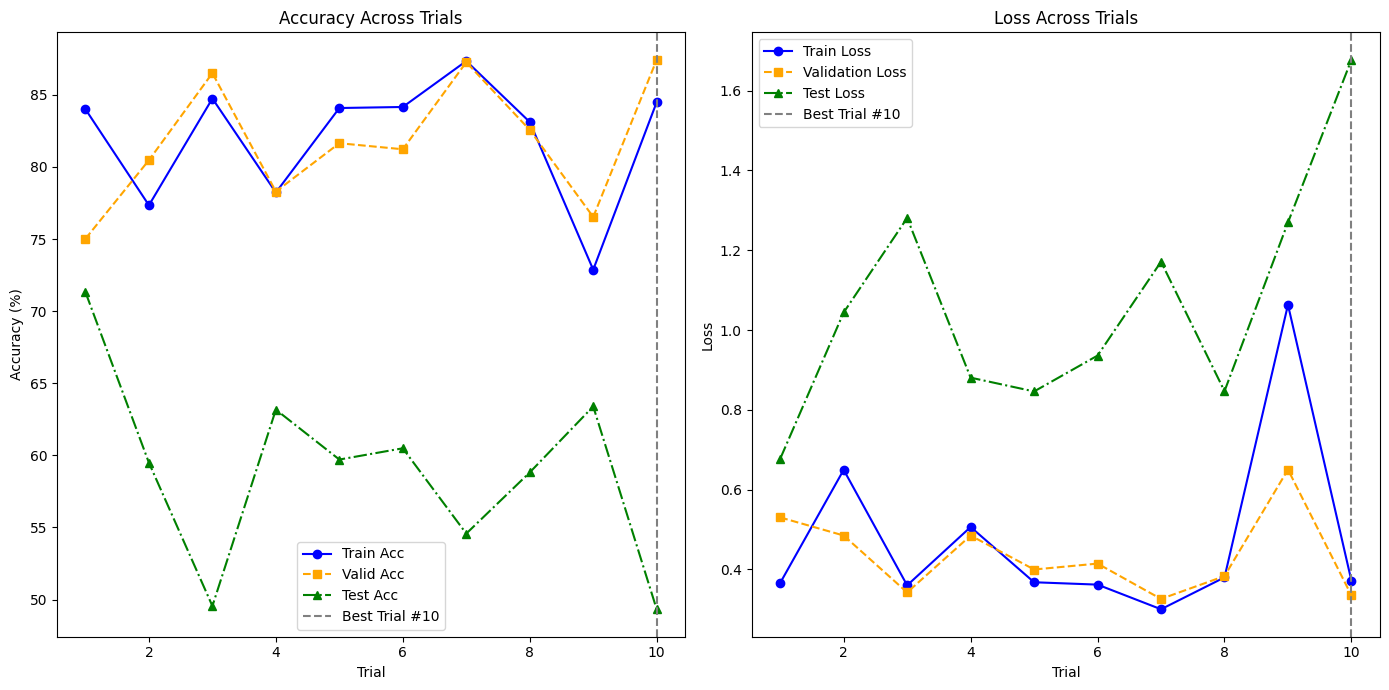

Best Trial: 10 with Validation Accuracy: 87.42665549036043%


In [10]:
train_accuracies = np.array([res['final_train_accuracy'] for res in results])
validation_accuracies = np.array([res['best_validation_accuracy'] for res in results])
test_accuracies = np.array([res['corresponding_test_accuracy'] for res in results])

train_losses = np.array([res['final_train_loss'] for res in results])
validation_losses = np.array([res['best_validation_loss'] for res in results])
test_losses = np.array([res['corresponding_test_loss'] for res in results])

trials = np.arange(1, len(results) + 1)

# Identifying the best trial based on validation accuracy
best_trial_acc = np.argmax(validation_accuracies) + 1
best_acc = validation_accuracies[best_trial_acc - 1]

# Plotting accuracies (training, validation, test)
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(trials, train_accuracies, 'o-', label='Train Acc', color='blue')
plt.plot(trials, validation_accuracies, 's--', label='Valid Acc', color='orange')
plt.plot(trials, test_accuracies, '^-.', label='Test Acc', color='green')
plt.axvline(x=best_trial_acc, color='gray', linestyle='--', label=f'Best Trial #{best_trial_acc}')
plt.title('Accuracy Across Trials')
plt.xlabel('Trial')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plotting losses (training, validation, and test)
plt.subplot(1, 2, 2)
plt.plot(trials, train_losses, 'o-', label='Train Loss', color='blue')
plt.plot(trials, validation_losses, 's--', label='Validation Loss', color='orange')
plt.plot(trials, test_losses, '^-.', label='Test Loss', color='green')
plt.axvline(x=best_trial_acc, color='gray', linestyle='--', label=f'Best Trial #{best_trial_acc}')
plt.title('Loss Across Trials')
plt.xlabel('Trial')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best Trial: {best_trial_acc} with Validation Accuracy: {best_acc}%")